### ECE/CS/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2022 ###


# Madison Bus Route Designing: Preliminary Report

Team Members: Rabeeya Hamid, Ai Guan, Naman Gupta

Data: 04/22/2022

*****

### Table of Contents

1. [Problem Description](#1.-Problem-Description)
2. [Data Collection](#2.-Data-Collection)
3. [Mathematical Model](#3.-Mathematical-Model)
4. [Preliminary Code Implementation](#4.-Code-Implementation)
5. [Preliminary Results and Analysis](#5.-Results-and-Analysis)


In [1]:
using PyPlot

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1423
ImportError: No module named site


LoadError: Failed to precompile PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee] to /Users/rabeeyahamid/.julia/compiled/v1.7/PyPlot/jl_e7Uu2D.

## 1. Problem Description


Based on the increasing need of public transportation, the City of Madison Metro Transit is proposing a major network redesign ([Transit Network Redesign](https://www.cityofmadison.com/metro/routes-schedules/transit-network-redesign)). Currently, they are surveying the students of UW-Madison and the residents of Madison for suggestions on their travel preferences, so that they can re-design the bus routes to meet the ridership demand and businesses. As University of Wisconsin-Madison students, our team thinks the redesign project would also have significant impact on our daily lives. 

The aim of the project is to model the routing design as a network optimization problem, so that we can propose the model as a part of their feedback survey. The family of network optimization problem includes assignment, critical path, max flow, shortest path, transportation, and min-cost flow problems. One of the primary results of the model is a network of arcs and nodes that illustrate the optimal routes for the nodes in a network ([Network Optimization](http://home.ubalt.edu/ntsbarsh/opre640a/partIII.htm#:~:text=The%20family%20of%20network%20optimization,called%20a%20vertex%2C%20or%20point)).

The project is a transportation problem in the network optimization problem family, and the nodes represent the bus stops, and the arcs represent the transportation flow between two stations. The model consist of three parts: decision variables, constraints, and objective function. We would like to model the optimal routes to meet the demand of ridership for each bus stop in Madison. Therefore, the objective function of the problem is to maximize the number of passengers boarding each bus on all the bus stops in Madison,  subject to fuel limitation of each bus, the capacity of a bus, routing regulations and ridership demand for each bus stop. 

## 2. Data Collection

The data utilized in the project is the publicly available data from the City of Madison website. Two datasets are selected corresponding to the 
   1.	Metro Transit Ridership by Stop | City of Madison Open Data.  [Data Source](https://data-cityofmadison.opendata.arcgis.com/datasets/cityofmadison::metro-transit-ridership-by-stop)
   2.	Metro Transit Bus Route Patterns | City of Madison Open Data. [Data Source](https://data-cityofmadison.opendata.arcgis.com/datasets/cityofmadison::metro-transit-bus-route-patterns/about)
   3.   Metro Transit Bus Stops | City of Madison Open Data. [Data Source](https://data-cityofmadison.opendata.arcgis.com/maps/metro-transit-bus-stops)
    4. Metro Transit Trips | City of Madison Open Data. [Data Source](https://data-cityofmadison.opendata.arcgis.com/datasets/cityofmadison::metro-transit-bus-route-trips)

* The first dataset contains a list of all the bus stops, their geographical location (longitude and latitude) and the ridership at that bus stop averaged over 12 days. We do not have distances between these bus stops, nor do we have connections between them, for which we propose the following approach. 
   *   We calculate the Geodesic Euclidean distance between the geographic position of the bus stops to define the distances between them. 
   *   These distances will be multiplied by a constant of proportionality to determine the fuel cost associated with each path. 

* The second dataset contains a list of present bus routes, the bus stops along the routes and the total ridership for the bus routes averaged over 12 days. 
    
* The third dataset maps the bus stops to the bus routes taken by all the buses in Madison. 
* The fourth dataset maps the bus routes to the bus stops 

Further, we load all the data and calculate the euclidean distance between each bus stop in Madison. We give a brief demo - 

In [2]:
# import Pkg;
# using Pkg
# Pkg.add("Cbc");
# Pkg.add("GraphRecipes");
# Pkg.add("LightGraphs");
# Pkg.add("SimpleWeightedGraphs");
# Pkg.add("SparseArrays");
# Pkg.add("CSV");
# Pkg.add("DataFrames");
# Pkg.add("Geodesy");

In [386]:
using JuMP, Plots, Cbc, GraphRecipes, LightGraphs, SimpleWeightedGraphs, SparseArrays

using CSV
using DataFrames

# import data set as a dataframe

# 1
ridership_data = CSV.read("data/Metro_Transit_Ridership_by_Stop.csv", DataFrame)
# 2
route_patterns_data = CSV.read("data/Metro_Transit_Bus_Route_Patterns.csv", DataFrame)
# 3
stops_data = CSV.read("data/Metro_Transit_Bus_Stops.csv", DataFrame)
# 4
weekday_data = CSV.read("data/Metro_Transit_Ridership_by_Route_Weekday.csv", DataFrame)
;

In [393]:
N = size(ridership_data,1)

2142

In [394]:
using Geodesy

stop_locations = Vector{LatLon{Float64}}()
intersections = []
stop_ids = []

for i in eachrow(ridership_data)
    int = i.IntersectionID
    if int ∉ intersections
        push!(intersections, int)
        x = LatLon(i.Lat, i.Lon)
        push!(stop_locations, x)
        push!(stop_ids, i.StopID)
    end
end

N = length(stops)

distances = zeros(N,N)

for i in 1:N
    for j in 1:N
        distances[i,j] = euclidean_distance(stop_locations[i], stop_locations[j])
    end
end


In [395]:
println(N)

27


The distance between each bus stop in Madison as a $n * n$ matrix.

In [396]:
distances

27×27 Matrix{Float64}:
    0.0     770.656   974.321   794.924  …   567.499  1995.25   2263.98
  770.656     0.0     263.84    510.88      1098.01   2427.85   2530.19
  974.321   263.84      0.0     447.575     1353.42   2427.08   2467.36
  794.924   510.88    447.575     0.0       1309.19   1979.56   2033.72
 1602.09    872.171   630.145   937.892     1969.24   2802.54   2719.57
  611.097  1026.19   1287.46   1292.8    …   151.159  2540.24   2855.19
  412.952   745.492   845.271   500.635      980.449  1725.45   1919.28
  567.934   439.384   703.178   824.767      691.759  2501.98   2698.84
  593.444   290.538   554.285   692.293      819.235  2451.13   2618.55
  317.611   779.899   908.545   596.784      882.511  1746.78   1971.81
  618.466   560.763   823.197   955.417  …   623.999  2589.01   2804.37
  266.902   616.788   771.358   532.066      817.949  1916.81   2122.48
  630.119   179.297   345.226   389.626     1029.76   2254.21   2372.3
    ⋮                                    ⋱

We map the bus stops (ids) to bus routes  that will help us model the optimal bus routes.

In [398]:
stop_route = Dict()

for i in eachrow(stops_data)
    if i.stop_id in stop_ids
        if i.Route != "None"
            stop_route[i.stop_id] = [parse(Int, d) for d in split(i.Route,",")] 
        end
    end
end

In [408]:
bus_route = 80

route_80_stops = []

for (s, r) in stop_route
    if bus_route in r
        append!(route_80_stops, s)
    end
end

# route_80_names = []

# for i in eachrow(stops_data)
#     if i.stop_id in route_80
#         println(i.stop_id,"   ",  i.stop_name)
#         push!(route_80_names, i.stop_name)
#     end
# end

length(route_80_stops)
# length(route_80_names)

# @show route_80_names

27

In [433]:
using Geodesy

# TODO: Create a function for generating a distance matrix

# stops = Vector{LatLon{Float64}}()
stops = []

for i in eachrow(ridership_data)
    if i.StopID in route_80_stops
        x = LatLon(i.Lat, i.Lon)
        if x ∉ stops
            push!(stops, x)
        end
    end
end

N = length(stops)

distances = zeros(N,N)

for i in 1:N
    for j in 1:N
        distances[i,j] = euclidean_distance(stops[i], stops[j])
    end
end

# DataFrame( distances, route_80_names[1:N], route_80_names[1:N])

# using NamedArrays
# d = NamedArray(distances, (route_80_names[1:N], route_80_names[1:N]), ("Stop", "Stop"))
# @show d;

distances



27×27 Matrix{Float64}:
    0.0     770.656   794.924   567.934  …  1827.86   1239.99   2310.75
  770.656     0.0     510.88    439.384     2183.39   1640.39   2517.02
  794.924   510.88      0.0     824.767     2521.94   1945.7    2923.67
  567.934   439.384   824.767     0.0       1747.44   1201.03   2106.75
  266.902   616.788   532.066   586.175     2069.93   1483.15   2528.2
  597.23    555.365   218.343   749.55   …  2375.32   1792.04   2806.86
  534.365   832.066  1129.34    401.62      1392.91    822.926  1816.26
  445.0     517.212   827.651   133.242     1704.36   1141.25   2097.15
  341.146   530.057   769.779   226.916     1752.25   1178.6    2167.21
 1505.53   1934.47   2231.44   1495.12       355.108   294.172   955.483
 2973.12   3106.69   3543.82   2719.45   …  1286.7    1797.75    684.221
 2827.93   3046.85   3453.6    2637.34      1049.7    1608.67    530.603
 2048.4    2431.34   2759.56   1994.2        252.249   815.247   602.739
    ⋮                                 

Creating $n*n$ Adjacency Matrix on the basis of StopIDs. We assume a bus stop with StopID 5 is connected to StopID 6.

In [452]:
# N = size(ridership_data,1)
# N = 47
Adj = zeros(N,N)

index_stopid = Dict()

for row in eachrow(ridership_data)
    if row.StopID in route_80_stops
        i = rownumber(row)
        index_stopid[i] = row.StopID
    end
end

for i in 1:N
    if i + 1 < N
        Adj[i, i + 1] = 1
        Adj[i + 1, i] = 1
    end
end

# Adj
# reshape(Adj, (n-1, n-1))


Adj = Adj[1:N-1,1:N-1]
D = distances[1:N-1,1:N-1]
;

Adj

26×26 Matrix{Float64}:
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [453]:
route_80_stops

27-element Vector{Any}:
  438
 2041
 2082
   61
   52
   10
 2240
   75
  706
 2061
 2027
 2014
 2091
    ⋮
    5
 2007
 2145
 2026
 2267
 2071
 2881
 2018
   39
 2034
 2039
 2054

In [454]:
ridership = Dict()

r = []

for i in eachrow(weekday_data)
    if i.StopID in route_80
        ridership[i.StopID] =  i.DailyBoardings
            push!(r, i.DailyBoardings)
    end
end

ridership
r
n
r = rand(1:3,n,1)
;

In [455]:
# r = weekday_data.DailyBoardings

In [456]:
n = N - 1
r
Adj
# D = distances

using Random

# n_i = rand(1:n)
# n_e = rand(1:n)
n_i  = 4
n_e = 7

# if n_i == n_e
#     n_e = rand(1:n)
# end

;

In [457]:
N, n

(27, 26)


## 3. Mathematical Model

For the preliminary report, our focus is to generate an illustrative demo of the model. It is a smaller bus network which consists of 8 bus stations.

### Parameters Given:
- Number of bus stops ```n``` : number of nodes in our network
- Adjacency Matrix ```Adj``` ($n \times n$) : describes connections between bus stops
- Distance Matrix ```D``` ($n \times n$): Euclidean distances between all bus stops
- Ridership vector ```r```($n \times 1$): the ridership demand at every bus stop
- Start node ```n_i```: the bus stop from where our bus starts
- End node ```n_e```: the bus stop where our bus route ends
- Distance (Fuel) limit ```f```: the distance our bus can travel in total

In [458]:
# n = 8

# Adj = [0 0 0 0 1 0 1 0;
#        0 0 1 0 0 1 0 0;
#        1 0 0 0 0 0 1 0;
#        0 0 0 0 1 0 0 1;
#        0 0 0 0 0 0 1 0;
#        0 0 0 1 0 0 0 1;
#        0 0 0 0 0 0 0 0;
#        1 0 0 1 0 0 1 0;]

# D = [0 4 6 3 10 1 8 10;
#      5 0 2 6 5 5 4 6;
#      1 8 0 4 2 7 2 3;
#      7 2 3 0 4 2 8 9;
#      2 3 9 4 0 5 1 2;
#      1 4 1 3 10 0 8 8;
#      5 8 2 6 5 2 0 6;
#      1 8 7 4 2 1 2 0]

# r = [4, 1, 8, 2, 9, 10, 5, 8]

# n_i = 2
# n_e = 7

# f = 20
# ;

### Plotting network:

In [459]:
membership = ones(Int, n,1)

membership[n_i] = 2
membership[n_e] = 3
membership
;

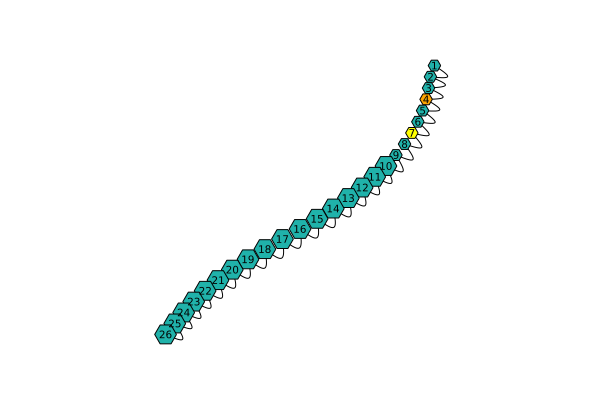

In [460]:
edgelabel_dict = Dict()
for i in 1:n
    for j in 1:n
        edgelabel_dict[(i, j)] = D[i, j]
    end
end

# membership = [1,2,1,1,1,1,3,1]
nodecolor = [colorant"lightseagreen", colorant"orange", colorant"yellow"]
# membership color
nodefillc = nodecolor[membership]

# # nodes size proportional to their degree
# nodesize = [Graphs.outdegree(g, v) for v in Graphs.vertices(g)]
# gplot(g, nodesize=nodesize)

graph = graphplot(Adj, names=1:n, curvature_scalar=0.06, markersize=0.2, markercolor=nodefillc)

## _Orange: Start node <br> Yellow: End node_

## _Ridership_: 
**BS 1: 4 <br> BS 2: 1 <br> BS 3: 8 <br> BS 4: 2 <br> BS 5: 9 <br> BS 6: 10 <br> BS 7: 5 <br> BS 8: 8 <br>**

### Parameters Calculated:
- Number of paths ```e```: number of edges in our network 
- Incidence matrix ```Inc```($n \times e$): describes the edges in our network.
- Edge costs ```d_e```($e \times 1$): the distance corresponding to edges in the network
- Rider intake ```r_e```($e \times 1$): the riders taken up after traveling to each edge
- Flow vector ```b``` ($n \times 1$): includes the start and end node

### Function for incidence matrix:
Defining function to calculate incidence matrix from adjacency matrix, taken from: https://github.com/sbromberger/LightGraphs.jl/issues/1489

In [461]:
# function my_incidence_matrix(G)
#     @show edges(G)
#     I = vcat([src(e) for e in edges(G)], [dst(e) for e in edges(G)])
#     J = vcat(collect(1:ne(G)), collect(1:ne(G)))
#     V = vcat(fill(-1, ne(G)), fill(1, ne(G)))
#     return sparse(I, J, V)
# end
# ;

### Calculating incidence matrix and number of edges:

In [462]:
using Graphs

dirGraph = Graphs.DiGraph(Adj) # converting adjacency matrix into a directed graph

Inc = Array(Graphs.incidence_matrix(dirGraph))
# Inc = Array(my_incidence_matrix(dirGraph)) # converting directed graph to an incidence matrix

e = size(Inc)[2] # number of edges

# n = n-1

50

### Defining edge costs, rider intake, and flow vector:

In [463]:
D

26×26 Matrix{Float64}:
    0.0     770.656   794.924   567.934  …   769.48   1827.86   1239.99
  770.656     0.0     510.88    439.384     1043.01   2183.39   1640.39
  794.924   510.88      0.0     824.767     1376.86   2521.94   1945.7
  567.934   439.384   824.767     0.0        603.67   1747.44   1201.03
  266.902   616.788   532.066   586.175      967.094  2069.93   1483.15
  597.23    555.365   218.343   749.55   …  1245.79   2375.32   1792.04
  534.365   832.066  1129.34    401.62       253.122  1392.91    822.926
  445.0     517.212   827.651   133.242      554.011  1704.36   1141.25
  341.146   530.057   769.779   226.916      609.05   1752.25   1178.6
 1505.53   1934.47   2231.44   1495.12       892.026   355.108   294.172
 2973.12   3106.69   3543.82   2719.45   …  2212.44   1286.7    1797.75
 2827.93   3046.85   3453.6    2637.34      2089.11   1049.7    1608.67
 2048.4    2431.34   2759.56   1994.2       1394.28    252.249   815.247
 2926.35   3161.88   3563.03   2749.32  

In [465]:
n
D
temp_D = D.*Adj
temp_r = zeros((n,n))

for i = 1:n
        temp_r[i, :] = r.*Adj[i, :]
end

d_e = zeros(0)
r_e = zeros(0)

for i = 1:n
    for j = 1:n
        if temp_D[i, j] != 0
            append!(d_e, temp_D[i, j])
        end
        if temp_r[i, j] != 0
            append!(r_e, temp_r[i, j])
        end
    end    
end


# TODO: Fix b's dimension
b = zeros(n)
#b = zeros(n - 1)

b[n_i] = -1
b[n_e] = 1
b = Int.(b)
;


**Decision variable:** <br>

$x$: all possible edges in the network, length = $e$ <br>
    $$ x =   \left\{
\begin{array}{ll}
      1 & \text{If the bus travels on that edge}  \\
      0 & \text{If the bus doesn NOT travel on that edge} \\
\end{array} 
\right.  $$

**Objective function:** <br>
$$ \max_{x} \text{    }r_e \cdot x$$

**Constraints:** <br>
  s.t. 
$$ \text{Inc}*x = b, $$
$$ d_e \cdot x <= f  $$


## 4. Code Implementation

In [466]:
f = 2000
cyc1 = floor.((Inc.+1)./2)
cyc2 = -1*ceil.((Inc.-1)./2)

2000

In [475]:
using LinearAlgebra

bus_route = Model(with_optimizer(Cbc.Optimizer,loglevel=0))

@variable(bus_route, x[1:e], Bin) # binary decision variable x that maps out the [ath]
cyc1 = floor.((Inc.+1)./2)
cyc2 = -1*ceil.((Inc.-1)./2)

@constraint(bus_route, Inc*x .== b) # nodal conservation
@constraint(bus_route, d_e'*x <= f) # fuel constraint
# @constraint(bus_route, cyc1*x .<= 1) # fuel constraint
# @constraint(bus_route, cyc2*x .<= 1) # fuel constraint

@objective(bus_route, Max, r_e'* x)  # maximize people getting on the bus
    
s = optimize!(bus_route)

termination_status(bus_route)
print(bus_route)

## 5. Results and Analysis

### Defining dictionary for converting edge index to path:

In [477]:
edgeIndex2path = Dict()
count = 1
for i = 1:n
    for j = 1:n
        if Adj[i, j] != 0
            edgeIndex2path[count] = (i, j)
            count = count + 1
        end
    end
end

sorted_edges = sort(collect(pairs(edgeIndex2path)), by=x->x[1])

for i in sorted_edges
    println(i)
end

Pair{Any, Any}(1, (1, 2))
Pair{Any, Any}(2, (2, 1))
Pair{Any, Any}(3, (2, 3))
Pair{Any, Any}(4, (3, 2))
Pair{Any, Any}(5, (3, 4))
Pair{Any, Any}(6, (4, 3))
Pair{Any, Any}(7, (4, 5))
Pair{Any, Any}(8, (5, 4))
Pair{Any, Any}(9, (5, 6))
Pair{Any, Any}(10, (6, 5))
Pair{Any, Any}(11, (6, 7))
Pair{Any, Any}(12, (7, 6))
Pair{Any, Any}(13, (7, 8))
Pair{Any, Any}(14, (8, 7))
Pair{Any, Any}(15, (8, 9))
Pair{Any, Any}(16, (9, 8))
Pair{Any, Any}(17, (9, 10))
Pair{Any, Any}(18, (10, 9))
Pair{Any, Any}(19, (10, 11))
Pair{Any, Any}(20, (11, 10))
Pair{Any, Any}(21, (11, 12))
Pair{Any, Any}(22, (12, 11))
Pair{Any, Any}(23, (12, 13))
Pair{Any, Any}(24, (13, 12))
Pair{Any, Any}(25, (13, 14))
Pair{Any, Any}(26, (14, 13))
Pair{Any, Any}(27, (14, 15))
Pair{Any, Any}(28, (15, 14))
Pair{Any, Any}(29, (15, 16))
Pair{Any, Any}(30, (16, 15))
Pair{Any, Any}(31, (16, 17))
Pair{Any, Any}(32, (17, 16))
Pair{Any, Any}(33, (17, 18))
Pair{Any, Any}(34, (18, 17))
Pair{Any, Any}(35, (18, 19))
Pair{Any, Any}(36, (19, 18))

### Finding the optimal path taken:

In [478]:
opt_path = value.(x)

# finding edges travelled using edgeIndex2path dictionary
path_taken_x = zeros(0)
path_taken_y = zeros(0)
for i = 1:e
    if opt_path[i] != 0
        temp = edgeIndex2path[i]
        append!(path_taken_x, temp[1] )
        append!(path_taken_y, temp[2] )
    end
end

# defining dictionary with 1 for travelled edges, 0 for untravelled edges
travelled_edges_dict = Dict()
for k = 1:length(path_taken_x)
    for i in 1:n
        for j in 1:n
            if i == path_taken_x[k] && j == path_taken_y[k] 
                travelled_edges_dict[(i, j)] = 1
            elseif haskey(travelled_edges_dict, (i, j))
                if travelled_edges_dict[(i, j)] == 1
                    travelled_edges_dict[(i, j)] = 1
                end
            else 
                travelled_edges_dict[(i, j)] = 0
            end
        end
    end
end

# printing the edges travelled on

print("The bus travelled on these edges: \n")
for i = 1:n
    for j = 1:n
        if travelled_edges_dict[(i, j)] != 0
            println((i, j))
        end
    end
end

The bus travelled on these edges: 
(4, 5)
(5, 6)
(6, 7)


### Finding nodes travelled:

In [479]:
nodes = 1:n

temp_path = zeros((n,n))

# defining temporary variable temp_path to store nodes travelled to for on each edge index
# (zeros need to be filtered out) 
for i = 1:n
        temp_path[i, :] = nodes.*Adj[i, :]
end

path = zeros(0)

# filtering out zeros
for i = 1:n
    for j = 1:n
        if temp_path[i, j] != 0
            append!(path, temp_path[i, j])
        end
    end    
end


# finding actual nodes travelled to using optimal edge vector x
temp_path = path.*opt_path

path = zeros(0)

# filtering out zeros again
for p in temp_path
    if p != 0
        append!(path, p)
    end
end

# defining membership based on nodes travelled to, 1 for not travelled to, 2 for travelled to
membership = ones(n)
for i = 1:n
    for p in path 
        if p == i
            membership[i] = 2
        end
    end
end

# start node is also travelled to 
membership[n_i] = 2

# convert to int for indexing
for i = 1:n
    membership[i] = convert(Int, membership[i])
end

# assigning colours, yellow for travelled to, seagreen for not
int_membership = Int.(membership)
nodecolor = [colorant"lightseagreen", colorant"orange", colorant"yellow"]
nodefillc = nodecolor[int_membership]
;

### Plotting final network:
Yellow bus stops: are included in route
Seagreen bus stops: are NOT included in route
Paths with 1: are included in route
Paths with 0: are NOT included in route

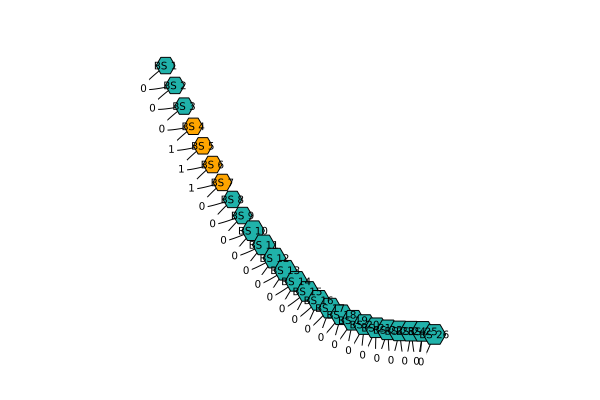

In [480]:
# edges are 1 for travelled on, 0 for not travelled on
graph = graphplot(Adj, names="BS ".*string.(1:n), curvature_scalar=0.11, edgelabel=travelled_edges_dict, markercolor=nodefillc)


The bus travelled on these edges: 
(1, 5)
(2, 3)
(3, 1)
(5, 7)

### Fuel used, and people picked up:

In [481]:
println("Fuel used: ", dot(d_e, opt_path))
println("People picked up: ", dot(r_e, opt_path) + r[n_i]) 

Fuel used: 1909.7031045217054
People picked up: 9.0


# Next Steps

Next, we will work on improving the mathematic model and show the solution to the optimization problem via suitable plots. 

* **Merge the optimization model with bus data**: We will further analyze the real bus network of Madison and utilize the full dataset of Madison metro transit to develop the model.  

* **Include reasonable estimations of unknown constraint variables**: We will include estimates of fuel value (considering the distances matrix), start and end nodes (considering the network map). 

* **Run X different buses simultaneously**: We will run X (around ~three) different buses simultaneously in the Madison bus system. We will ideally want that these bus routes do not overlap (or try and minimize overlap).

* **Cycle constraint**: We want to make sure that no cycles exists in the network, for this we will have to add a constraint such that no bus travels on the same edge/path twice.

* **Bus capacity constraint**: Currently we're assuming that the number of people entering and leaving the bus are always equal so we aren't taking into account bus capacity, and we aren't keeping track of passengers at evert bus stop. It will be interesting to see if we can implement a probability function for people leaving at a bus stop, and then use that to place a limit on the bus capacity. Which will limit the number of people we can take up at each bus stop. 

* **Sensitvity analysis:** Once we have our final results, we want to do a sensitivity analysis to analyze the fuel and capacity constraints.  